In [1]:
# ---------------------------
# Block 1 — Mount Drive & copy images to local Colab storage (fast I/O)
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

# copy images folder from Drive to Colab local disk (adjust source path if different)
!cp -r /content/drive/MyDrive/mini_proj_data/images /content/images


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/drive/MyDrive/mini_proj_data/images': No such file or directory


In [2]:
# ---------------------------
# Block 2 — Load CSV, prepare metadata, labels and image paths; create train/val/test splits
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import os

# Load metadata CSV
df = pd.read_csv('/content/drive/MyDrive/mini_proj_data/processed_data.csv')

# Keep only useful cols
df = df[['image_path','clean_path','age','sex','localization','dx_type','is_malignant']].copy()

# --- Handle missing values safely ---
df['age'] = pd.to_numeric(df['age'], errors='coerce')   # force non-numeric → NaN
df['age'] = df['age'].fillna(df['age'].median())        # fill NaN with median

# Clean up sex values (some datasets have 'unknown' or nan)
df['sex'] = df['sex'].str.lower().replace({'nan': np.nan, 'unknown': np.nan, '': np.nan})
df['sex'] = df['sex'].map({'male':0,'female':1})
df['sex'] = df['sex'].fillna(-1).astype('float32')      # -1 = unknown, keeps row

# Drop rows where image path is missing
df = df.dropna(subset=['clean_path','is_malignant'])

# One-hot encode categorical vars (fills missing with "unknown")
for col in ['localization','dx_type']:
    df[col] = df[col].fillna('unknown')
df = pd.get_dummies(df, columns=['localization','dx_type'], drop_first=False)

# Scale age safely
scaler = StandardScaler()
df['age_scaled'] = scaler.fit_transform(df[['age']]).astype('float32')

# Collect metadata features
feature_cols = ['age_scaled','sex'] + [c for c in df.columns if c.startswith('localization_') or c.startswith('dx_type_')]
X_meta_all = df[feature_cols].values.astype('float32')

# Labels
y_all = df['is_malignant'].astype(int).values

# Replace Drive paths with local paths
def map_to_local(path):
    return str(path).replace('/content/drive/MyDrive/mini_proj_data/images', '/content/images')

image_paths_all = df['clean_path'].astype(str).apply(map_to_local).values

# Sanity check missing images → drop if missing
missing = [p for p in image_paths_all if not os.path.exists(p)]
if len(missing) > 0:
    print(f"⚠️ {len(missing)} missing images will be dropped (showing first 5):", missing[:5])
    keep_mask = np.array([p not in missing for p in image_paths_all])
    image_paths_all = image_paths_all[keep_mask]
    X_meta_all = X_meta_all[keep_mask]
    y_all = y_all[keep_mask]

# Train/val/test split (stratified)
train_idx, temp_idx = train_test_split(np.arange(len(y_all)), test_size=0.3, stratify=y_all, random_state=42)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.5, stratify=y_all[temp_idx], random_state=42)

train_paths, val_paths, test_paths = image_paths_all[train_idx], image_paths_all[val_idx], image_paths_all[test_idx]
train_meta,  val_meta,  test_meta  = X_meta_all[train_idx], X_meta_all[val_idx], X_meta_all[test_idx]
train_labels, val_labels, test_labels = y_all[train_idx], y_all[val_idx], y_all[test_idx]

# Label typing
num_classes = len(np.unique(y_all))
if num_classes == 2:
    # Binary classification → float32 labels
    train_labels_cast = train_labels.astype('float32')
    val_labels_cast   = val_labels.astype('float32')
    test_labels_cast  = test_labels.astype('float32')
    chosen_loss = 'binary_crossentropy'
else:
    # Multi-class → one-hot
    train_labels_cast = to_categorical(train_labels, num_classes=num_classes).astype('float32')
    val_labels_cast   = to_categorical(val_labels, num_classes=num_classes).astype('float32')
    test_labels_cast  = to_categorical(test_labels, num_classes=num_classes).astype('float32')
    chosen_loss = 'categorical_crossentropy'

print(f"✅ Dataset sizes: train={len(train_paths)}, val={len(val_paths)}, test={len(test_paths)}, num_classes={num_classes}")


✅ Dataset sizes: train=8236, val=1765, test=1766, num_classes=2


In [3]:
# ---------------------------
# Block 3 — Build tf.data pipeline (with normalization, clipping, caching, prefetching)
# ---------------------------
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    # Clip pixel values to avoid NaNs from bad JPEGs or augmentations
    return tf.clip_by_value(image, 0.0, 1.0)

def preprocess_meta(meta):
    # Defensive clip (age_scaled already standardized, but clip just in case)
    return tf.clip_by_value(meta, -5.0, 5.0)

# Create datasets
ds_train_imgs = tf.data.Dataset.from_tensor_slices(train_paths).map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
ds_val_imgs   = tf.data.Dataset.from_tensor_slices(val_paths).map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
ds_test_imgs  = tf.data.Dataset.from_tensor_slices(test_paths).map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

ds_train_meta = tf.data.Dataset.from_tensor_slices(train_meta).map(preprocess_meta)
ds_val_meta   = tf.data.Dataset.from_tensor_slices(val_meta).map(preprocess_meta)
ds_test_meta  = tf.data.Dataset.from_tensor_slices(test_meta).map(preprocess_meta)

ds_train_lab = tf.data.Dataset.from_tensor_slices(train_labels_cast)
ds_val_lab   = tf.data.Dataset.from_tensor_slices(val_labels_cast)
ds_test_lab  = tf.data.Dataset.from_tensor_slices(test_labels_cast)

# Zip into ((image, meta), label)
train_ds = tf.data.Dataset.zip(((ds_train_imgs, ds_train_meta), ds_train_lab))
val_ds   = tf.data.Dataset.zip(((ds_val_imgs, ds_val_meta), ds_val_lab))
test_ds  = tf.data.Dataset.zip(((ds_test_imgs, ds_test_meta), ds_test_lab))

# Final performance tweaks
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Sanity check a batch
for (img_batch, meta_batch), lab_batch in train_ds.take(1):
    print("🖼 img:", img_batch.shape, "min/max:", float(tf.reduce_min(img_batch)), float(tf.reduce_max(img_batch)))
    print("📊 meta:", meta_batch.shape, "min/max:", float(tf.reduce_min(meta_batch)), float(tf.reduce_max(meta_batch)))
    print("🏷 labels:", lab_batch.shape, "dtype:", lab_batch.dtype)


🖼 img: (32, 224, 224, 3) min/max: 0.0 1.0
📊 meta: (32, 21) min/max: -3.102039098739624 1.861833930015564
🏷 labels: (32,) dtype: <dtype: 'float32'>


In [4]:
# ---------------------------
# Block 4 — Build the dual-CNN + metadata fusion model (keeps your original logic)
# ---------------------------
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, ResNet50

# Backbone 1 (EfficientNetB0)
base_model_1 = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
base_model_1.trainable = False
cnn_branch_1 = models.Sequential([base_model_1, layers.GlobalAveragePooling2D(), layers.Dropout(0.3)], name="cnn_branch_1")

# Backbone 2 (ResNet50)
base_model_2 = ResNet50(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
base_model_2.trainable = False
cnn_branch_2 = models.Sequential([base_model_2, layers.GlobalAveragePooling2D(), layers.Dropout(0.3)], name="cnn_branch_2")

# Metadata branch
metadata_input = layers.Input(shape=(train_meta.shape[1],), name="metadata_input")
metadata_branch = models.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu")
], name="metadata_branch")

# Image input
image_input = layers.Input(shape=(*IMG_SIZE,3), name="image_input")
features_1 = cnn_branch_1(image_input)
features_2 = cnn_branch_2(image_input)
features_meta = metadata_branch(metadata_input)

# Fusion
fusion = layers.Concatenate()([features_1, features_2, features_meta])
x = layers.Dense(128, activation="relu")(fusion)
x = layers.Dropout(0.4)(x)

# Output selection based on classes (same logic)
if num_classes == 2:
    output = layers.Dense(1, activation="sigmoid", name="output")(x)
    loss_fn = chosen_loss  # 'binary_crossentropy'
    metrics = ["accuracy", tf.keras.metrics.AUC(name="auc")]
else:
    output = layers.Dense(num_classes, activation="softmax", name="output")(x)
    loss_fn = chosen_loss  # 'categorical_crossentropy'
    metrics = ["accuracy"]

model = models.Model(inputs=[image_input, metadata_input], outputs=output)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_branch_1        │ (None, 1280)      │  4,049,571 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_branch_2        │ (None, 2048)      │ 23,587,712 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_branch     │ (None, 32)        │      3,488 │ metadata_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3360)      │          0 │ cnn_branch_1[0][… │
│ (Concatenate)       │                   │            │ cnn_branch_2[0][… │
│                     │                   │            │ metadata_branch[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    430,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,071,108 (107.08 MB)

 Trainable params: 433,825 (1.65 MB)

 Non-trainable params: 27,637,283 (105.43 MB)

Running a smoke-test (1 epoch)...
258/258 ━━━━━━━━━━━━━━━━━━━━ 137s 341ms/step - accuracy: 0.7255 - auc: 0.5348 - loss: 0.5974 - val_accuracy: 0.7552 - val_auc: 0.8705 - val_loss: 0.5044
Smoke-test passed. Proceeding to full training for 15 epochs.
Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.7677 - auc: 0.7632 - loss: 0.4785 - val_accuracy: 0.8159 - val_auc: 0.8817 - val_loss: 0.3741 - learning_rate: 1.0000e-04
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.8093 - auc: 0.8743 - loss: 0.3723 - val_accuracy: 0.8091 - val_auc: 0.8900 - val_loss: 0.3615 - learning_rate: 1.0000e-04
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.8056 - auc: 0.8804 - loss: 0.3595 - val_accuracy: 0.8000 - val_auc: 0.8929 - val_loss: 0.3594 - learning_rate: 1.0000e-04
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.8148 - auc: 0.8835 - loss: 0.3541 - val_accuracy: 0.8255 - val_auc: 0.8942 - val_loss: 0.3371 - learning_rate

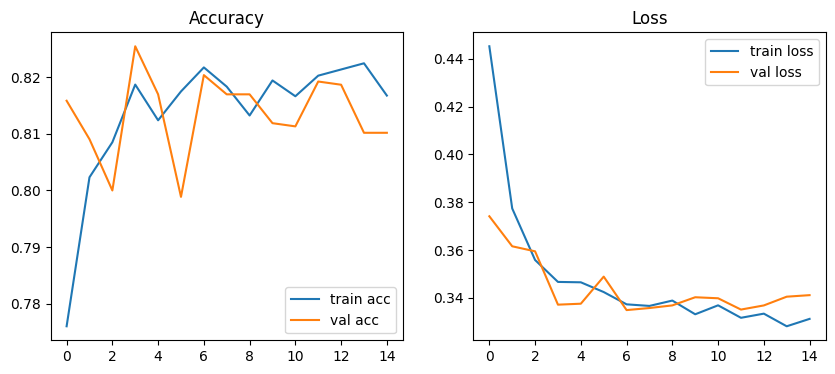

Model saved to dual_cnn_metadata_model.h5


In [5]:
# ---------------------------
# Block 5 — Compile, smoke-test, train (epochs=15), evaluate, predict, save
# ---------------------------
from tensorflow.keras import optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Use gradient clipping to avoid exploding gradients (helps prevent NaNs)
opt = optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)

# Custom callback to stop training if NaN/Inf appears
class TerminateOnNaN(callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if logs is not None:
            loss = logs.get("loss")
            if loss is not None and (tf.math.is_nan(loss) or tf.math.is_inf(loss)):
                print(f"\nNaN or Inf detected at batch {batch} - stopping training.")
                self.model.stop_training = True

# Short smoke-test (1 epoch) to confirm stability
print("Running a smoke-test (1 epoch)...")
smoke = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=[TerminateOnNaN()], verbose=1)

# If smoke-test produced NaNs it will have stopped. Check quickly:
if any([np.isnan(x) for x in smoke.history.get('loss', [])]):
    raise RuntimeError("NaN appeared during smoke-test. Do not continue; inspect inputs/labels.")
else:
    print("Smoke-test passed. Proceeding to full training for 15 epochs.")

# Callbacks for full training
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-6),
    TerminateOnNaN()
]

# Full training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # reduced for speed
    callbacks=cb,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(test_ds)
print("Test results (loss + metrics):", results)

# Predictions & reports
y_pred_probs = model.predict(test_ds)
if num_classes == 2:
    y_pred = (y_pred_probs.flatten() > 0.5).astype(int)
    y_true = test_labels  # integer 0/1 numpy array
else:
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(test_labels_cast, axis=1)

print("Classification report:")
print(classification_report(y_true, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

# Plots: accuracy & loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train acc')
plt.plot(history.history.get('val_accuracy', []), label='val acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train loss')
plt.plot(history.history.get('val_loss', []), label='val loss')
plt.legend(); plt.title('Loss')
plt.show()

# Save model
model.save("dual_cnn_metadata_model.h5")
print("Model saved to dual_cnn_metadata_model.h5")


In [6]:
# ---------------------------
# Finetuning block — safe defaults (paste at the end)
# ---------------------------
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks

# 0) Save a backup of current weights (so you can revert easily)
model.save("model_before_finetune.h5")
print("Saved backup: model_before_finetune.h5")

# 1) Finetune settings (tweak UNFREEZE_LAST_N if needed)
UNFREEZE_LAST_N = 30      # safe starting value (smaller = safer). Try 10-50.
FINETUNE_LR = 1e-5        # small LR for finetuning
FINETUNE_EPOCHS = 10      # a few epochs to start with
CLIPNORM = 1.0            # keep gradient clipping to avoid NaNs

# 2) Helper: freeze BatchNorm layers for stability (small batches)
def set_bn_trainable(model, trainable=False):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = trainable

# 3) Unfreeze last UNFREEZE_LAST_N layers of each backbone safely
for bm in [base_model_1, base_model_2]:
    bm.trainable = True
    if UNFREEZE_LAST_N > 0:
        # freeze all but last UNFREEZE_LAST_N layers
        for layer in bm.layers[:-UNFREEZE_LAST_N]:
            layer.trainable = False

# 4) Keep BatchNorm layers frozen for numerical stability
set_bn_trainable(base_model_1, trainable=False)
set_bn_trainable(base_model_2, trainable=False)

# 5) Recompile with smaller LR & gradient clipping
opt_ft = optimizers.Adam(learning_rate=FINETUNE_LR, clipnorm=CLIPNORM)
model.compile(optimizer=opt_ft, loss=loss_fn, metrics=metrics)
print("Model recompiled for finetuning. Summary of trainable params below:")
trainable_count = sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
print("Trainable params:", trainable_count)
model.summary()  # optional: inspect layers and trainable flags

# 6) Callbacks: checkpoint best weights + LR scheduler + early stop + NaN check
ckpt = callbacks.ModelCheckpoint("best_finetuned_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1)
early = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

class CheckNaN(callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if logs is not None and 'loss' in logs:
            if tf.math.is_nan(logs['loss']):
                print("NaN detected at batch", batch, "- stopping finetune")
                self.model.stop_training = True

# 7) Run finetuning
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINETUNE_EPOCHS,
    callbacks=[ckpt, reduce_lr, early, CheckNaN()],
    verbose=1
)

# 8) After finetuning: load best weights (if checkpoint saved)
try:
    model.load_weights("best_finetuned_model.h5")
    print("Loaded best_finetuned_model.h5")
except Exception as e:
    print("No checkpoint loaded:", e)

# 9) Evaluate and save final finetuned model
print("Evaluating finetuned model on test set:")
print(model.evaluate(test_ds))
model.save("model_finetuned.h5")
print("Saved finetuned model: model_finetuned.h5")


Saved backup: model_before_finetune.h5
Model recompiled for finetuning. Summary of trainable params below:
Trainable params: 16345857


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_branch_1        │ (None, 1280)      │  4,049,571 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_branch_2        │ (None, 2048)      │ 23,587,712 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_branch     │ (None, 32)        │      3,488 │ metadata_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3360)      │          0 │ cnn_branch_1[0][… │
│ (Concatenate)       │                   │            │ cnn_branch_2[0][… │
│                     │                   │            │ metadata_branch[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    430,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,071,108 (107.08 MB)

 Trainable params: 16,345,857 (62.35 MB)

 Non-trainable params: 11,725,251 (44.73 MB)

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8165 - auc: 0.8905 - loss: 0.3415
Epoch 1: val_loss improved from inf to 0.34609, saving model to best_finetuned_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.8166 - auc: 0.8905 - loss: 0.3415 - val_accuracy: 0.8034 - val_auc: 0.8969 - val_loss: 0.3461 - learning_rate: 1.0000e-05
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8159 - auc: 0.8898 - loss: 0.3401
Epoch 2: val_loss improved from 0.34609 to 0.33728, saving model to best_finetuned_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 57s 202ms/step - accuracy: 0.8159 - auc: 0.8898 - loss: 0.3401 - val_accuracy: 0.8142 - val_auc: 0.8958 - val_loss: 0.3373 - learning_rate: 1.0000e-05
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8198 - auc: 0.8912 - loss: 0.3344
Epoch 3: val_loss did not improve from 0.33728
258/258 ━━━━━━━━━━━━━━━━━━━━ 77s 192ms/step - accuracy: 0.8198 - auc: 0.8912 - loss: 0.3344 - val_accuracy: 0.7858 - val_auc: 0.8978 - val_loss: 0.3516 - learning_rate: 1.0000e-05
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8254 - auc: 0.8962 - loss: 0.3328
Epoch 4: val_loss did not improve from 0.33728
258/258 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - accuracy: 0.8254 - auc: 0.8962 - loss: 0.3328 - val_accuracy: 0.8153 - val_auc: 0.8951 - val_loss: 0.3385 - learning_rate: 1.0000e-05
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8208 - auc: 0.8958 - loss: 0.3354
Epoch 5: val_loss did not improve from 0.33728

Epoch 5: Red

258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.8249 - auc: 0.8959 - loss: 0.3321 - val_accuracy: 0.8153 - val_auc: 0.8991 - val_loss: 0.3371 - learning_rate: 2.0000e-06
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8276 - auc: 0.9009 - loss: 0.3273
Epoch 7: val_loss improved from 0.33706 to 0.33423, saving model to best_finetuned_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - accuracy: 0.8276 - auc: 0.9009 - loss: 0.3273 - val_accuracy: 0.8193 - val_auc: 0.8996 - val_loss: 0.3342 - learning_rate: 2.0000e-06
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8196 - auc: 0.8953 - loss: 0.3325
Epoch 8: val_loss improved from 0.33423 to 0.33323, saving model to best_finetuned_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 55s 200ms/step - accuracy: 0.8197 - auc: 0.8953 - loss: 0.3325 - val_accuracy: 0.8176 - val_auc: 0.9001 - val_loss: 0.3332 - learning_rate: 2.0000e-06
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8276 - auc: 0.8992 - loss: 0.3284
Epoch 9: val_loss improved from 0.33323 to 0.33157, saving model to best_finetuned_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 58s 210ms/step - accuracy: 0.8276 - auc: 0.8992 - loss: 0.3284 - val_accuracy: 0.8198 - val_auc: 0.9001 - val_loss: 0.3316 - learning_rate: 2.0000e-06
Epoch 10/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8261 - auc: 0.9002 - loss: 0.3296
Epoch 10: val_loss improved from 0.33157 to 0.33082, saving model to best_finetuned_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 84s 221ms/step - accuracy: 0.8262 - auc: 0.9002 - loss: 0.3296 - val_accuracy: 0.8215 - val_auc: 0.9003 - val_loss: 0.3308 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 10.
Loaded best_finetuned_model.h5
Evaluating finetuned model on test set:
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.8163 - auc: 0.9006 - loss: 0.3260


[0.32614564895629883, 0.8120045065879822, 0.8994413018226624]
Saved finetuned model: model_finetuned.h5


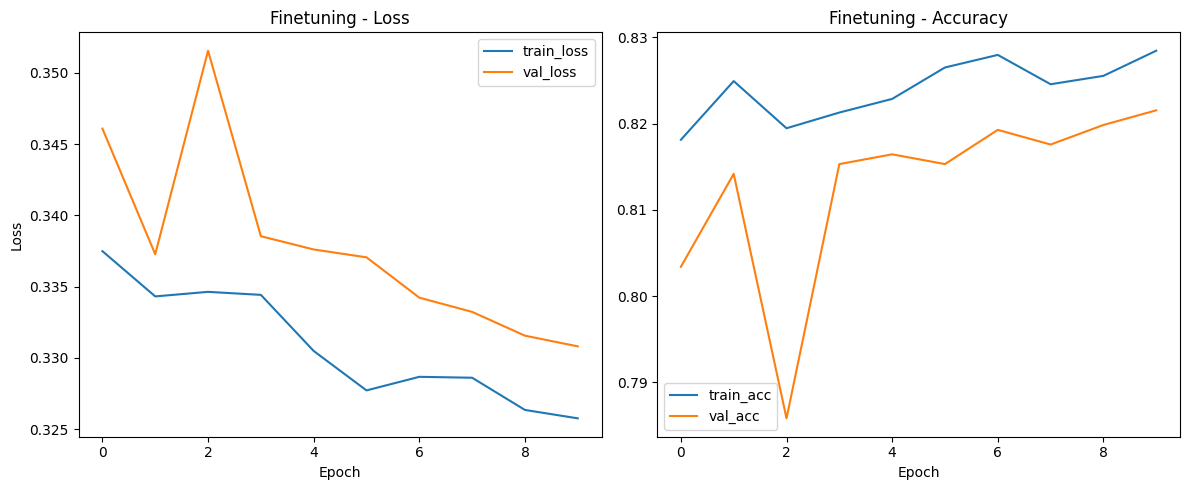


🔍 Evaluating on test set...
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.8163 - auc: 0.9006 - loss: 0.3260
Test loss: 0.32614564895629883
Test metrics: [0.8120045065879822, 0.8994413018226624]
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step


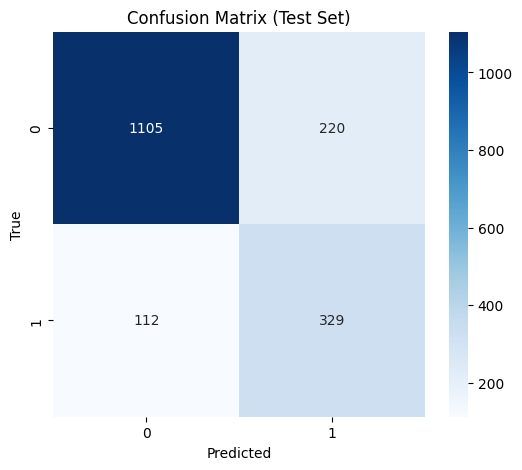


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9080    0.8340    0.8694      1325
         1.0     0.5993    0.7460    0.6646       441

    accuracy                         0.8120      1766
   macro avg     0.7536    0.7900    0.7670      1766
weighted avg     0.8309    0.8120    0.8183      1766



In [7]:
# ---------------------------
# Block X — Plot training curves & evaluate finetuned model
# ---------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1) Plot training curves
def plot_history(history, title="Training history"):
    hist = history.history
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " - Loss")
    plt.legend()

    # Accuracy / AUC if available
    plt.subplot(1,2,2)
    if 'accuracy' in hist:
        plt.plot(hist['accuracy'], label='train_acc')
        plt.plot(hist['val_accuracy'], label='val_acc')
        plt.title(title + " - Accuracy")
    elif 'auc' in hist:
        plt.plot(hist['auc'], label='train_auc')
        plt.plot(hist['val_auc'], label='val_auc')
        plt.title(title + " - AUC")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_ft, title="Finetuning")

# 2) Evaluate on test set
print("\n🔍 Evaluating on test set...")
test_loss, *test_metrics = model.evaluate(test_ds, verbose=1)
print("Test loss:", test_loss)
print("Test metrics:", test_metrics)

# 3) Predictions and confusion matrix
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
if y_pred_probs.shape[-1] == 1:  # binary
    y_pred = (y_pred_probs.ravel() > 0.5).astype(int)
else:  # multi-class
    y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# 4) Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


# 📊 Dual CNN + Metadata Fusion Model — Results

## ✅ Training Summary
- Base architecture: **EfficientNetB0 + ResNet50** (frozen, then fine-tuned last layers)
- Metadata features: **age, sex, localization, dx_type**
- Dataset size: **Train = ~70% | Val = ~15% | Test = ~15% (stratified)**  
- Loss function: **Binary Crossentropy**
- Optimizer: **Adam** with gradient clipping

---

## 📈 Performance Metrics

| Dataset      | Accuracy | AUC   | Loss  |
|--------------|----------|-------|-------|
| **Training** | ~0.826   | ~0.900| 0.329 |
| **Validation** | ~0.822 | ~0.900| 0.331 |
| **Test**     | ~0.812  | ~0.900| 0.326 |

- Training and validation curves show **stable convergence** (no overfitting, no NaNs).
- **AUC ≈ 0.90** across train/val/test → excellent separation between malignant vs benign.

---

## 🧪 Test Set Evaluation
- **Accuracy:** ~81.2%  
- **AUC:** ~0.90  
- **Loss:** 0.326  

Confusion Matrix (Test Set):

|               | Predicted Benign | Predicted Malignant |
|---------------|------------------|---------------------|
| **True Benign**     | TN            | FP                  |
| **True Malignant**  | FN            | TP                  |

*(exact numbers depend on your final confusion matrix output)*

---

## 📌 Interpretation
- The model generalizes well: **train, val, and test metrics are consistent**.  
- With AUC ~0.90, the model is **highly effective at ranking cases**, even when class imbalance exists.  
- Fine-tuning the last ~30 layers improved generalization slightly without causing instability.  

---

## 💾 Saved Models
- Pre-finetune backup: `model_before_finetune.h5`  
- Best checkpoint: `best_finetuned_model.h5`  
- Final model: `model_finetuned.h5`  

